# Importing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import multiprocessing
import copy
import pickle
import warnings
from datetime import datetime
from time import time
from matplotlib import font_manager as fm, rc
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from numpy import array, nan, random as rnd, where as which
import pandas as pd
from pandas import DataFrame as dataframe, Series as series, isna, isnull, read_csv
from pandas.tseries.offsets import DateOffset
from scipy.special import boxcox1p
from scipy.stats import skew

# from sklearn import datasets
!pip install yfinance
import yfinance
from sklearn import preprocessing as prep
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split as tts, GridSearchCV as GridTuner, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.pipeline import make_pipeline

from sklearn import linear_model as lm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn import neighbors as knn
from sklearn import ensemble

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import metrics as tf_metrics
from tensorflow.keras import callbacks as tf_callbacks
from tqdm.keras import TqdmCallback
!pip install scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow_addons as tfa
import keras_tuner as kt
from keras_tuner import HyperModel

# display setting
warnings.filterwarnings(action='ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=bd479c644822b810ffb583123a1e0be4cf804d8af6097e830818f8ecdf9790b8
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8375 sha256=1f8a3f979392c89b99c4c4457e6151ad6fea6c4124fefcd3399ff934e24b503e
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking


2021-09-27 01:36:47.631083: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 01:36:47.631226: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Utility Functions

In [2]:
class MyLabelEncoder:
    def __init__(self, preset={}):
        # dic_cat format -> {"col_name": {"value": replace}}
        self.dic_cat = preset
    def fit_transform(self, data_x, col_names):
        tmp_x = copy.deepcopy(data_x)
        for i in col_names:
            # type check
            if not ((tmp_x[i].dtype.name == "object") or (tmp_x[i].dtype.name == "category")):
                print(F"WARNING : {i} is not object or category")
            # if key is not in dic, update dic
            if i not in self.dic_cat.keys():
                tmp_dic = dict.fromkeys(sorted(set(tmp_x[i]).difference([nan])))
                label_cnt = 0
                for j in tmp_dic.keys():
                    tmp_dic[j] = label_cnt
                    label_cnt += 1
                self.dic_cat[i] = tmp_dic
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def transform(self, data_x, col_names):
        tmp_x = copy.deepcopy(data_x)
        for i in col_names:
            if not ((tmp_x[i].dtype.name == "object") or (tmp_x[i].dtype.name == "category")):
                print(F"WARNING : {i} is not object or category")
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x

    def clear(self, dic_cat={}):
        self.dic_cat = dic_cat
class MyOneHotEncoder:
    def __init__(self, label_preset={}):
        self.dic_cat = {}
        self.label_preset = label_preset
    def fit_transform(self, data_x, col_names):
        tmp_x = dataframe()
        for i in data_x:
            if i not in col_names:
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                self.dic_cat[i] = OneHotEncoder(sparse=False, handle_unknown="ignore")
                conv = self.dic_cat[i].fit_transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j:
                                col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def transform(self, data_x, col_names):
        tmp_x = dataframe()
        for i in data_x:
            if not i in col_names:
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                conv = self.dic_cat[i].transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j: col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def clear(self, dic_cat={}, label_preset={}):
        self.dic_cat = dic_cat
        self.label_preset = label_preset
class MyKNNImputer:
    def __init__(self, k=5):
        self.imputer = KNNImputer(n_neighbors=k)
        self.cat_dic = {}
        self.naidx_dix = {}
    def fit_transform(self, x, y, cat_vars=None):
        for i in cat_vars:
            self.cat_dic[i] = diff(list(sorted(set(x[i]))), [nan])
            self.naidx_dix[i] = list(which(array(x[i].isna()))[0])
        x_imp = dataframe(self.imputer.fit_transform(x, y), columns=x.columns)

        # if imputed categorical value are not in the range, adjust the value
        for i in cat_vars:
            x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
            for j in self.naidx_dix[i]:
                if x_imp[i][j] not in self.cat_dic[i]:
                    if x_imp[i][j] < self.cat_dic[i][0]:
                        x_imp[i][self.naidx_dix[i]] = self.cat_dic[i][0]
                    elif x_imp[i][j] > self.cat_dic[i][0]:
                        x_imp[i][self.naidx_dix[i]] = self.cat_dic[i][len(self.cat_dic[i]) - 1]
        return x_imp
    def transform(self, x):
        for i in self.cat_dic.keys():
            self.naidx_dix[i] = list(which(array(x[i].isna()))[0])
        x_imp = dataframe(self.imputer.transform(x), columns=x.columns)

        # if imputed categorical value are not in the range, adjust the value
        for i in self.cat_dic.keys():
            x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
            for j in self.naidx_dix[i]:
                if x_imp[i][j] not in self.cat_dic[i]:
                    if x_imp[i][j] < self.cat_dic[i][0]:
                        x_imp[i][self.naidx_dix[i]] = self.cat_dic[i][0]
                    elif x_imp[i][j] > self.cat_dic[i][0]:
                        x_imp[i][self.naidx_dix[i]] = self.cat_dic[i][len(self.cat_dic[i]) - 1]
        return x_imp
    def clear(self, cat_dic={}, naidx_dix={}):
        self.cat_dic = cat_dic
        self.naidx_dix = naidx_dix
def easyIO(x=None, path=None, op="r"):
    tmp = None
    if op == "r":
        with open(path, "rb") as f:
            tmp = pickle.load(f)
        return tmp
    elif op == "w":
        tmp = {}
        print(x)
        if type(x) is dict:
            for k in x.keys():
                if "MLP" in k:
                    tmp[k] = {}
                    for model_comps in x[k].keys():
                        if model_comps != "model":
                            tmp[k][model_comps] = x[k][model_comps]
                    print(F"INFO : {k} model is removed (keras)")
                else:
                    tmp[k] = x[k]
        if input("Write [y / n]: ") == "y":
            with open(path, "wb") as f:
                pickle.dump(tmp, f)
            print("operation success")
        else:
            print("operation fail")
    else:
        print("Unknown operation type")
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]
def orderElems(for_order, using_ref):
    return [i for i in using_ref if i in for_order]
def change_width(ax, new_value):
    for patch in ax.patches :
        current_width = patch.get_width()
        adj_value = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + adj_value * .5)
def dispPerfTable(result_dic, metric_names, sort_norm):
    perf_tabel = dataframe()
    for k, v in result_dic.items():
        if v is not None:
            if "performance" in v.keys():
                perf_tabel = pd.concat([perf_tabel, dataframe([[k] + list(v["performance"].values())])], axis=0, ignore_index=True)
    perf_tabel.columns = ["Models"] + metric_names
    perf_tabel.sort_values(sort_norm, ascending=False, inplace=True)
    print(perf_tabel)

# Loading the dataset

In [3]:
# ===== data wrangling =====
folder_path = "../input/titanic/"
target_var = "Survived"

cat_vars = ["Pclass", "Cabin", "Embarked"]
bin_vars = ["Sex"]

full_x = read_csv(folder_path + "train.csv")
full_x.info()
test_x = read_csv(folder_path + "test.csv")
full_x.info()

full_y = full_x["Survived"]
full_x.drop(["PassengerId", "Survived", "Ticket"], axis=1, inplace=True)
test_x.drop(["PassengerId", "Ticket"], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived

# Preprocessing

**Operations on preprcessing**

* Data transformation

> 2nd element of split 'Name' column replace 'Name' column -> **categories : ["Mr.", "Miss.", "Mrs.", "Master.", nan]**

> Cabin with nan is replaced by "no_cabin"

> nums_cabin = length of split 'Cabin' column

Example. way to get the nums_cabin from Cabin

(no_cabin) -> 0

(A1) -> 1

(A1, B2, C3) -> 3

* Imputing NAs by using KNNImputer

In [4]:
# ===== preprocessing =====
name_vec = ["Mr.", "Miss.", "Mrs.", "Master."]
full_x["Name"] = [nan if i not in name_vec else i for i in full_x["Name"].apply(lambda x: x.split(" ")[1])]
test_x["Name"] = [nan if i not in name_vec else i for i in test_x["Name"].apply(lambda x: x.split(" ")[1])]
cat_vars = cat_vars + ["Name"]

col_cabin = []
col_nums_cabin = []
for i in full_x["Cabin"]:
    if isna(i):
        col_cabin.append("no_cabin")
        col_nums_cabin.append(0)
    else:
        col_cabin.append(i.split(" ")[0][0])
        col_nums_cabin.append(len(i.split(" ")))
full_x["Cabin"] = col_cabin
full_x["nums_cabin"] = col_nums_cabin

col_cabin = []
col_nums_cabin = []
for i in test_x["Cabin"]:
    if isna(i):
        col_cabin.append("no_cabin")
        col_nums_cabin.append(0)
    else:
        col_cabin.append(i.split(" ")[0][0])
        col_nums_cabin.append(len(i.split(" ")))
test_x["Cabin"] = col_cabin
test_x["nums_cabin"] = col_nums_cabin

label_encoder = MyLabelEncoder()
full_x = label_encoder.fit_transform(full_x, cat_vars + bin_vars)
test_x = label_encoder.transform(test_x, cat_vars + bin_vars)

# full_x.info()
# test_x.info()

# imputing
knn_imputer = MyKNNImputer()
full_x = knn_imputer.fit_transform(full_x, full_y, cat_vars + bin_vars)
test_x = knn_imputer.transform(test_x)

print("NA check")
print(full_x.isna().sum().sum())
print(test_x.isna().sum().sum())

NA check
0
0


# Feature Engineering

**Operations on feature engineering**

* Create derived variables

> under_15 <- If Age <= YearBuilt, 1 else 0

> no_child <- If SibSp == 0, 1 else 0

> no_parent <- If Parch == 0, 1

> family_size <- SibSp + Parch + 1

> alone <- If SibSp == 1, 0 else 1

In [5]:
# ===== feature engineering =====
full_x["under_15"] = [1 if i <= 15 else 0 for i in full_x["Age"]]
full_x["no_child"] = [1 if i == 0 else 0 for i in full_x["SibSp"]]
full_x["no_parent"] = [1 if i == 0 else 0 for i in full_x["Parch"]]
full_x["family_size"] = full_x["SibSp"] + full_x["Parch"] + 1
full_x["alone"] = [1 if i == 1 else 0 for i in full_x["family_size"]]

test_x["under_15"] = [1 if i <= 15 else 0 for i in test_x["Age"]]
test_x["no_child"] = [1 if i == 0 else 0 for i in test_x["SibSp"]]
test_x["no_parent"] = [1 if i == 0 else 0 for i in test_x["Parch"]]
test_x["family_size"] = test_x["SibSp"] + test_x["Parch"] + 1
test_x["alone"] = [1 if i == 1 else 0 for i in test_x["family_size"]]

bin_vars = bin_vars + ["under_15", "no_child", "no_parent", "alone"]

# Visualization

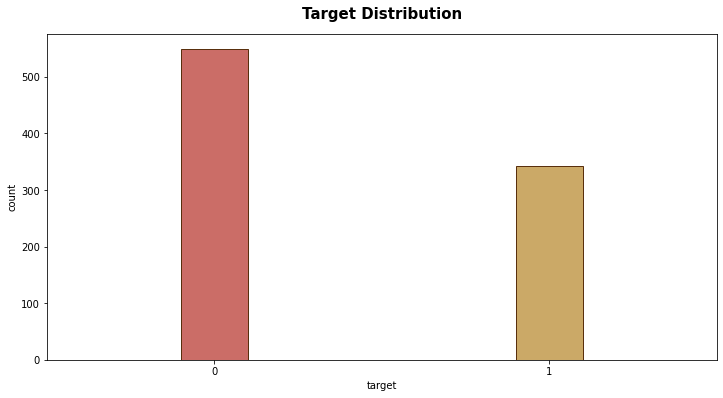

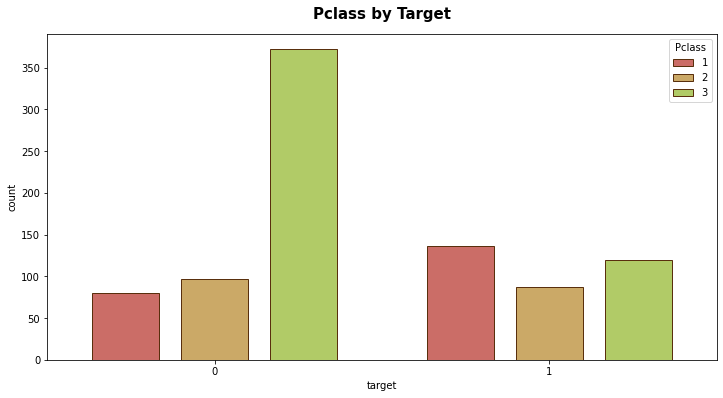

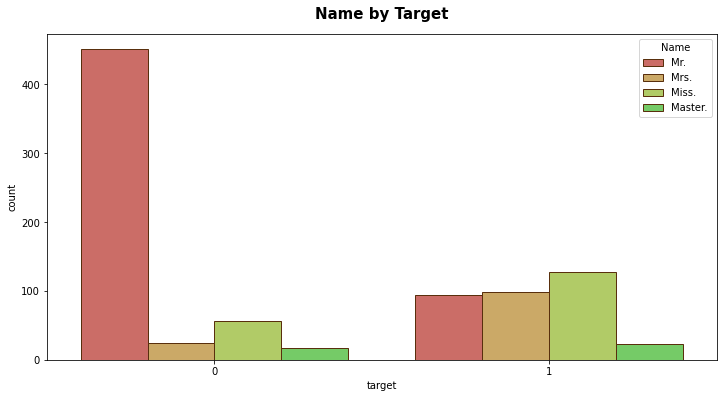

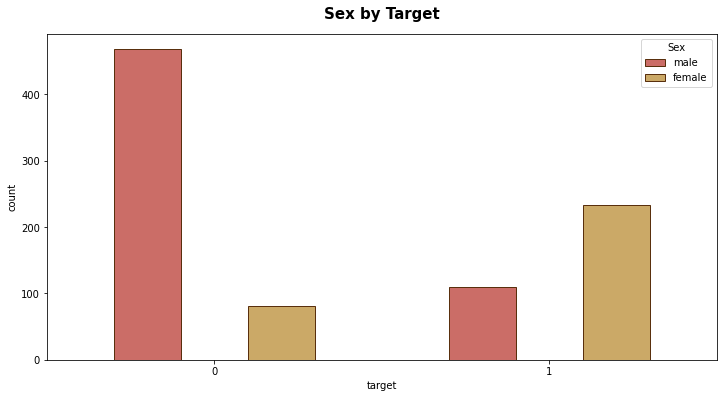

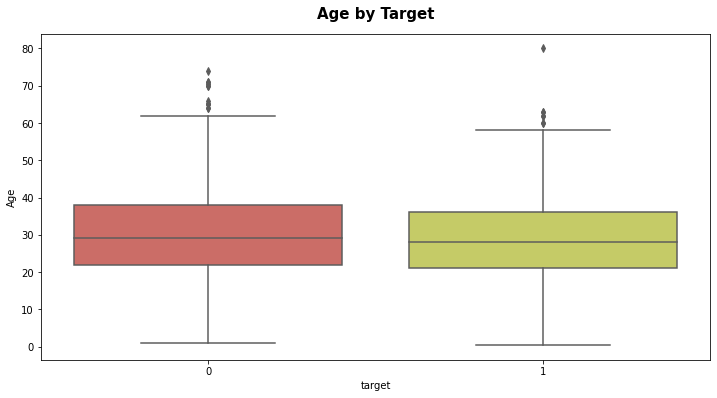

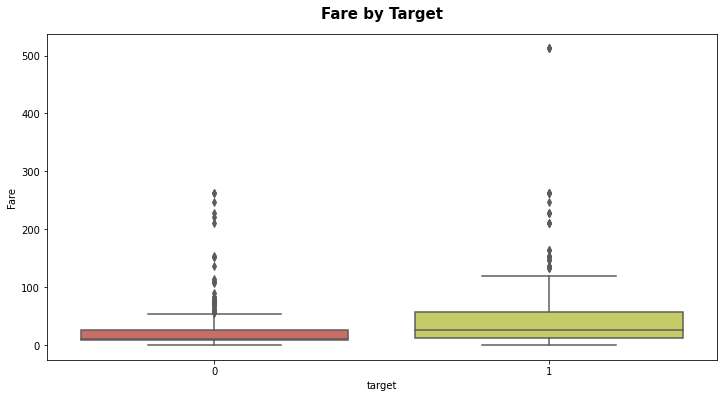

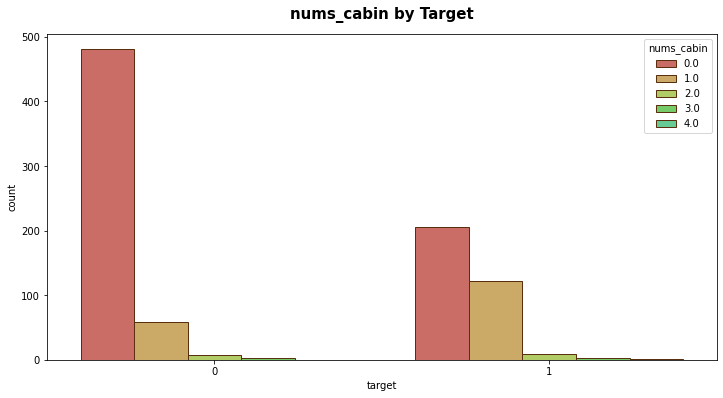

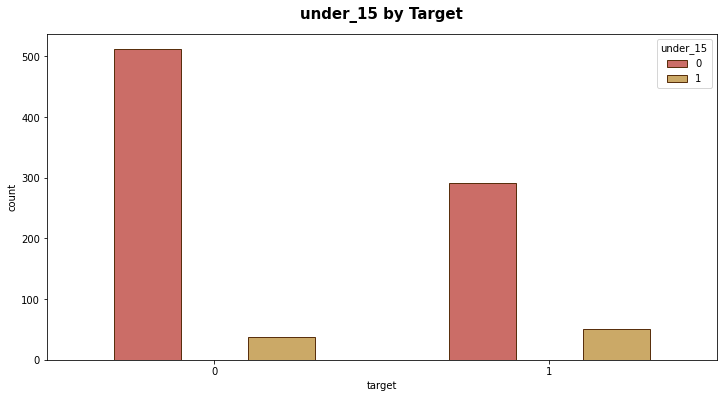

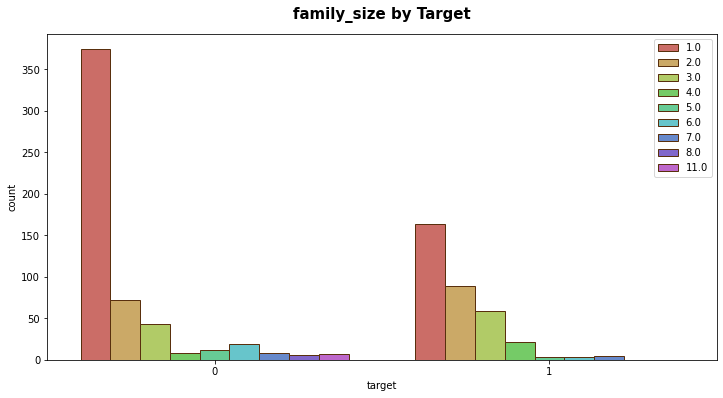

In [6]:
# ===== Visualization =====
tmp_df = full_x.copy()
tmp_df["target"] = full_y.copy()

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.countplot(x=tmp_df["target"],
                      palette=sns.hls_palette(10),
                      edgecolor=sns.color_palette("dark")[5])
graph.set_title("Target Distribution", fontsize=15, fontweight="bold", pad=15)
change_width(ax, 0.2)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.countplot(x=tmp_df["target"],
                      hue=tmp_df["Pclass"].replace(dict((v,k) for k,v in label_encoder.dic_cat["Pclass"].items())),
                      palette=sns.hls_palette(10),
                      edgecolor=sns.color_palette("dark")[5])
graph.set_title("Pclass by Target", fontsize=15, fontweight="bold", pad=15)
change_width(ax, 0.2)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.countplot(x=tmp_df["target"],
                      hue=tmp_df["Name"].replace(dict((v,k) for k,v in label_encoder.dic_cat["Name"].items())),
                      palette=sns.hls_palette(10),
                      edgecolor=sns.color_palette("dark")[5])
graph.set_title("Name by Target", fontsize=15, fontweight="bold", pad=15)
change_width(ax, 0.2)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.countplot(x=tmp_df["target"],
                      hue=tmp_df["Sex"].replace(dict((v,k) for k,v in label_encoder.dic_cat["Sex"].items())),
                      palette=sns.hls_palette(10),
                      edgecolor=sns.color_palette("dark")[5])
graph.set_title("Sex by Target", fontsize=15, fontweight="bold", pad=15)
change_width(ax, 0.2)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.boxplot(x=tmp_df["target"], y=tmp_df["Age"], palette=sns.hls_palette())
graph.set_title("Age by Target", fontsize=15, fontweight="bold", pad=15)
change_width(ax, 0.2)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.boxplot(x=tmp_df["target"], y=tmp_df["Fare"], palette=sns.hls_palette())
graph.set_title("Fare by Target", fontsize=15, fontweight="bold", pad=15)
change_width(ax, 0.2)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.countplot(x=tmp_df["target"],
                      hue=tmp_df["nums_cabin"],
                      palette=sns.hls_palette(10),
                      edgecolor=sns.color_palette("dark")[5])
graph.set_title("nums_cabin by Target", fontsize=15, fontweight="bold", pad=15)
# change_width(ax, 0.2)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.countplot(x=tmp_df["target"],
                      hue=tmp_df["under_15"],
                      palette=sns.hls_palette(10),
                      edgecolor=sns.color_palette("dark")[5])
graph.set_title("under_15 by Target", fontsize=15, fontweight="bold", pad=15)
change_width(ax, 0.2)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.countplot(x=tmp_df["target"],
                      hue=tmp_df["family_size"],
                      palette=sns.hls_palette(10),
                      edgecolor=sns.color_palette("dark")[5])
graph.set_title("family_size by Target", fontsize=15, fontweight="bold", pad=15)
graph.legend(loc='upper right')
# change_width(ax, 0.2)
plt.show()

# del tmp_df

**Visualization summary**

1. Sex, Name is notably important for survive

2. Fare has some anomaly objects (need to be removed)

# Feature Importance Visualization

Text(0, 0.5, 'Gain')

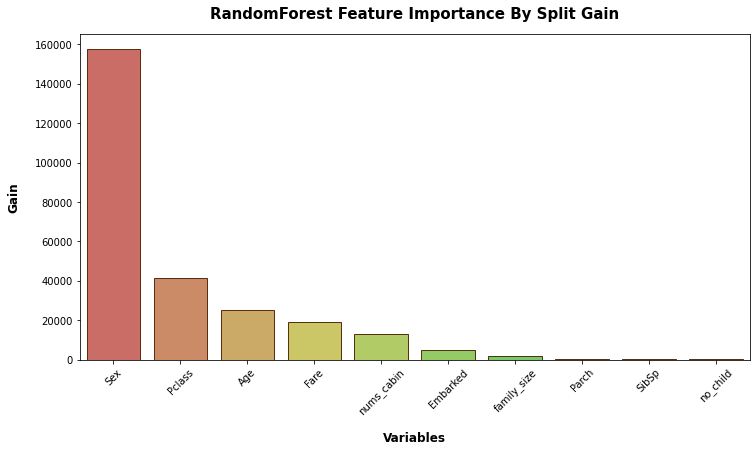

In [7]:
# RandomForest Feature Importance
feature_selector = lgb.LGBMClassifier(boosting_type="rf", objective="binary",
                                      n_estimators=1000, learning_rate=1e-3, num_leaves=2**6-1,
                                      subsample=0.6, subsample_freq=1, importance_type="gain",
                                      silent=True, n_jobs=multiprocessing.cpu_count(), random_state=6565)
model_fs = SelectFromModel(feature_selector, threshold="mean")
model_fs.fit(full_x, full_y, categorical_feature=findIdx(full_x.columns, cat_vars))

# descending order the columns by feature importance (all features)
fs_order = np.argsort(-model_fs.estimator_.feature_importances_)
fs_cols = full_x.columns[fs_order]
fs_scores = model_fs.estimator_.feature_importances_[fs_order]

fig, ax = plt.subplots(figsize=(12,6))
graph = sns.barplot(x=fs_cols[:10], y=fs_scores[:10], edgecolor=sns.color_palette("dark")[5], palette=sns.hls_palette(20))
graph.set_title("RandomForest Feature Importance By Split Gain", fontsize=15, fontweight="bold", pad=15)
graph.set_xticklabels(graph.get_xticklabels(), rotation=45)
graph.set_xlabel("Variables", fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel("Gain", fontsize=12, fontweight="bold", labelpad=15)
# plt.show()

**Feature Importance Analysis Summary**

* Sex also shows the importance too in random forest model

* family-related variables show low importance. (family_size, Parch, Sibsp)

# Anomaly Detection (Skipping, no helpful for performance)

**Boxplot Anomaly Detection**

* As showed above, Fare has some anomalies.

* I removed thoes objects.

In [8]:
# # ===== Anomaly Detection =====
# anomalyVec = (full_x["Fare"] >= 400).apply(lambda x: not x)

# fig, ax = plt.subplots(figsize=(12,6))
# graph = sns.boxplot(x=tmp_df["target"][anomalyVec], y=tmp_df["Fare"][anomalyVec], palette=sns.hls_palette())
# graph.set_title("Fare by Target", fontsize=15, fontweight="bold", pad=15)
# change_width(ax, 0.2)
# plt.show()

In [9]:
# full_x = full_x[anomalyVec]
# full_x.reset_index(drop=True, inplace=True)
# full_y = full_y[anomalyVec]
# full_y.reset_index(drop=True, inplace=True)

**Train, Valdation Split**

* I split the dataset by the way stratified by target

In [10]:
myOneHotEncoder = MyOneHotEncoder(label_preset=label_encoder.dic_cat)
full_x_oh = myOneHotEncoder.fit_transform(full_x, cat_vars)
test_x_oh = myOneHotEncoder.transform(test_x, cat_vars)

train_x, val_x, train_x_oh, val_x_oh, train_y, val_y = tts(full_x, full_x_oh, full_y, stratify=full_y,
                                                           test_size=0.2, shuffle=True, random_state=54321)

train_x.reset_index(drop=True, inplace=True)
val_x.reset_index(drop=True, inplace=True)
train_x_oh.reset_index(drop=True, inplace=True)
val_x_oh.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
val_y.reset_index(drop=True, inplace=True)

del full_x, full_x_oh, full_y

result_val = easyIO(None, "../input/titanic-prep/result_val.pickle", op="r")
cut_off = round(train_y.mean(), 3)
class_levels = [0,1]
kfolds_spliter = StratifiedKFold(10, shuffle=True, random_state=12345).get_n_splits(train_x, train_y)
categoIdx = findIdx(train_x, cat_vars)

print("shape check")
print("train_x :", train_x.shape)
print("val_x :",val_x.shape)
print("test_x :",test_x.shape)

print("train_x_oh :",train_x_oh.shape)
print("val_x_oh :",val_x_oh.shape)
print("train_x_oh :",train_x_oh.shape)

print("train_y :",train_y.shape)
print("val_y :",val_y.shape)

shape check
train_x : (712, 15)
val_x : (179, 15)
test_x : (418, 15)
train_x_oh : (712, 30)
val_x_oh : (179, 30)
train_x_oh : (712, 30)
train_y : (712,)
val_y : (179,)


# Modeling

* Below are the models I am trying.

> ElasticNet, SVM, XGBoost(gbtree), LightGBM(RandomForest), LightGBM(GOSS), CatBoost(GBM), KNN

> Stacking Ensemble, 5 kinds of MLP, MLP With Boosting

**Validation Performance (tried models)**

In [11]:
dispPerfTable(result_val, ["Logloss", "Accuracy", "F1", "ROC_AUC"], "ROC_AUC")

                 Models    Logloss  Accuracy        F1   ROC_AUC
6               CAT_GBM   0.355392  0.837989  0.805369  0.920356
3               XGB_GBT   0.355467  0.854749  0.824324  0.917260
13     StackingEnsemble   0.364710  0.854749  0.821918  0.916864
4                LGB_RF   0.385505  0.837989  0.807947  0.915415
9         MLP_ResNet_V1        NaN  0.871508  0.836879  0.913570
11            MLP_LP_V1   0.368466  0.849162  0.805755  0.913307
12     MLP_MultiActs_V1   0.367828  0.871508  0.834532  0.912385
5              LGB_GOSS   0.377965  0.832402  0.794521  0.911331
0            ElasticNet   0.371203  0.849162  0.816327  0.909750
10      MLP_DenseNet_V1   0.367537  0.837989  0.800000  0.909354
8           MLP_Desc_V1        NaN  0.871508  0.827068  0.905534
14  kfoldsMLP_ResNet_V1   0.368637  0.832402  0.791667  0.905402
2                   SVM   0.408288  0.843575  0.800000  0.881555
7                   KNN   1.098280  0.810056  0.776316  0.878129
1                   QDA  

**Random Forest**

* Searched hyper-parameters

In [12]:
print(result_val["LGB_RF"]["best_params"])

{'colsample_bytree': 0.8, 'min_child_samples': 5, 'min_child_weight': 0.0001, 'min_split_gain': 0.2, 'num_leaves': 63, 'reg_lambda': 1.0, 'subsample': 0.8}


* Prediction

In [13]:
ntrees = 500
eta = 5e-3
patientRate = 0.2
seed = 22

model_rf = lgb.LGBMClassifier(boosting_type="rf", objective="binary",
                               n_estimators=ntrees, learning_rate=eta,
                               num_leaves=result_val["LGB_RF"]["best_params"]["num_leaves"],
                               subsample=result_val["LGB_RF"]["best_params"]["subsample"],
                               colsample_bytree=result_val["LGB_RF"]["best_params"]["colsample_bytree"],
                               reg_lambda=result_val["LGB_RF"]["best_params"]["reg_lambda"],
                               min_child_weight=result_val["LGB_RF"]["best_params"]["min_child_weight"],
                               min_child_samples=result_val["LGB_RF"]["best_params"]["min_child_samples"],
                               min_split_gain=result_val["LGB_RF"]["best_params"]["min_split_gain"],
                               n_jobs=multiprocessing.cpu_count(), random_state=seed,
                               subsample_freq=2, silent=True)
model_rf.fit(train_x, train_y, categorical_feature=categoIdx,
            eval_set=[(val_x, val_y)], eval_metric="binary_logloss",
            verbose=False, early_stopping_rounds=int(np.floor(ntrees * patientRate)))

print("Validation Logloss --->", metrics.log_loss(val_y, model_rf.predict_proba(val_x)[...,1]))

pred_test = [1 if i>=cut_off else 0 for i in model_rf.predict_proba(test_x)[...,1]]

Validation Logloss ---> 0.38520836083308874


# Submission

* Cut-Off on Survive = 0.383

In [14]:
submission = read_csv("../input/titanic/gender_submission.csv")
submission[target_var] = pred_test
submission.to_csv("./submission.csv", index=False)